# Notebook to Go Through the Steps in Calculating the Boundary Conditions #

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import importlib

import pandas as pd

import xarray as xr

import PI_BOUND_COND as pibc

In [48]:
importlib.reload(pibc)

<module 'PI_BOUND_COND' from '/ocean/sallen/allen/research/Meopar/ANALYSIS/analysis-susan/notebooks/Carbon/PI_BOUND_COND.py'>

### Choose our Day (September 8, 2015 and our profile #10)
Read in the LiveOcean Boundary Conditions and Convert to Observation Units

In [3]:
date = datetime.datetime(2015, 9, 8)
model_year = date.year # used for plotting
ds = xr.open_dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2015m09d08.nc')

In [49]:
ds = pibc.calculate_sigma(ds)
ds, conversion_uMolar_to_umolkg = pibc.change_to_umol_kg(ds)
ds = pibc.calculate_Sp_theta(ds)
ds = pibc.calculate_pressure(ds)

Conversion already done, not run again


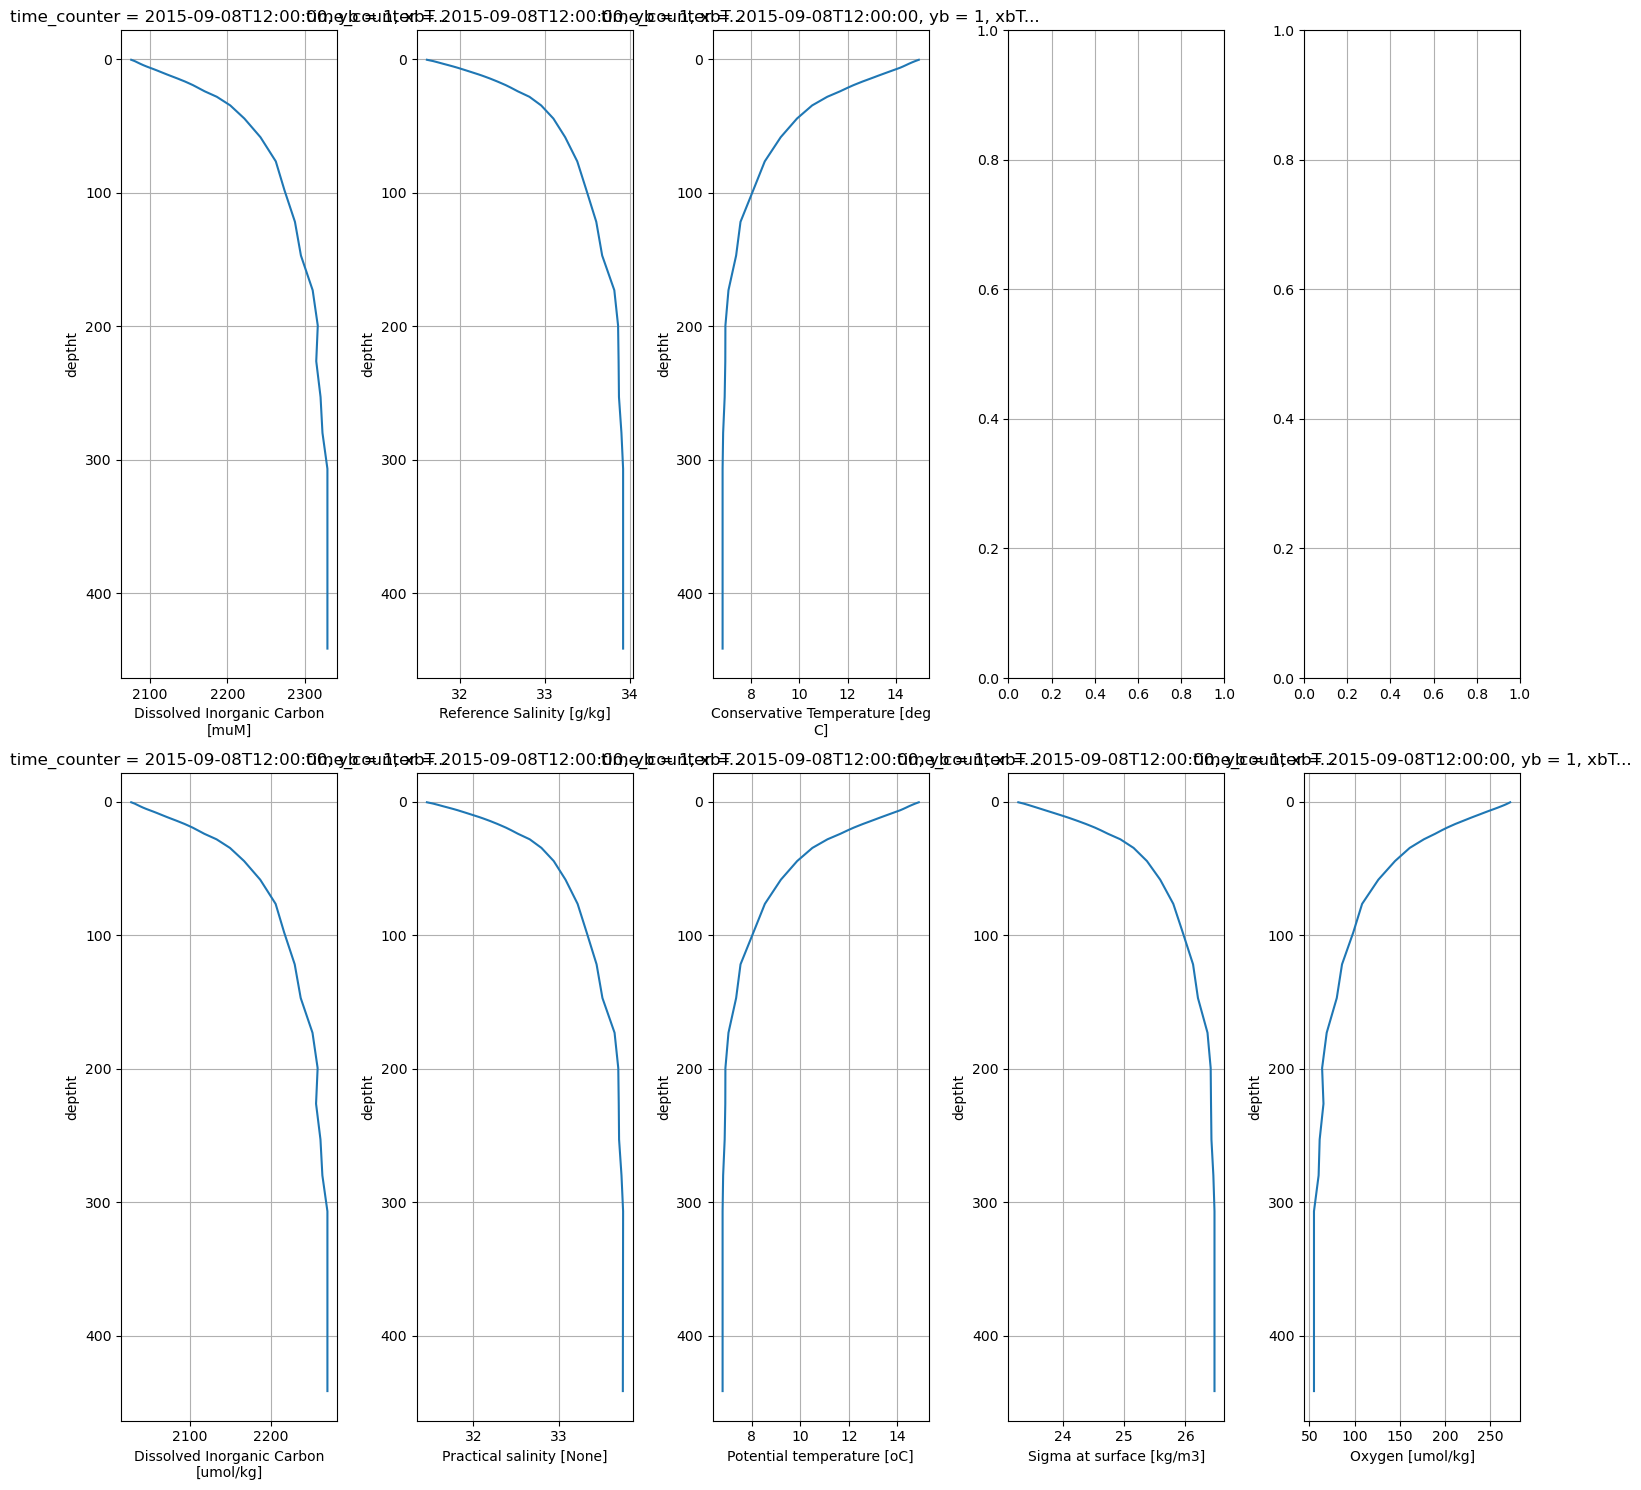

In [5]:
# Plot
fig, axs = plt.subplots(2, 5, figsize=(15, 15))
ds.DIC_uMol[0, :, 0, 10].plot(ax = axs[0, 0], y='deptht', yincrease=False);
ds.vosaline[0, :, 0, 10].plot(ax = axs[0, 1], y='deptht', yincrease=False);
ds.votemper[0, :, 0, 10].plot(ax = axs[0, 2], y='deptht', yincrease=False);
ds.DIC[0, :, 0, 10].plot(ax = axs[1, 0], y='deptht', yincrease=False);
ds.practical_salinity[0, :, 0, 10].plot(ax = axs[1, 1], y='deptht', yincrease=False);
ds.potential_temperature[0, :, 0, 10].plot(ax = axs[1, 2], y='deptht', yincrease=False);
ds.sigma[0, :, 0, 10].plot(ax = axs[1, 3], y='deptht', yincrease=False);
ds.OXY[0, :, 0, 10].plot(ax = axs[1, 4], y='deptht', yincrease=False);

for row in range(2):
    for ax in axs[row]:
        ax.grid()
fig.tight_layout();

## Step 1 Find when isopycnal last at surface

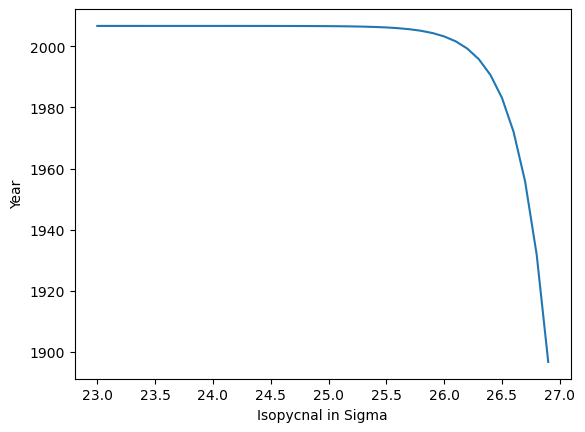

In [6]:
# plot
params0 = 0.1301889490932413
params1 = 3.8509914822057825
params2 = 8.301166081413104 + model_year - 2015
ssigmas = np.arange(23, 27, 0.1)
pycnal_last_at_surface = 2015 - (params0 * np.exp(-params1 * (25.15 - ssigmas)) + params2)
plt.plot(ssigmas, pycnal_last_at_surface);
plt.ylabel('Year')
plt.xlabel('Isopycnal in Sigma');

Image with the Data 
![title](../../../analysis_tereza/notebooks/PI_CARBON_PAPER/PI_BOUND_COND/CLEAN/FigureS8_Jarnikova_PI.png)

I note that the fit is poor for sigma < 25: but we don't use it for that, so all okay

In [7]:
ds = pibc.calculate_year_isopyncal_surface(ds, model_year)

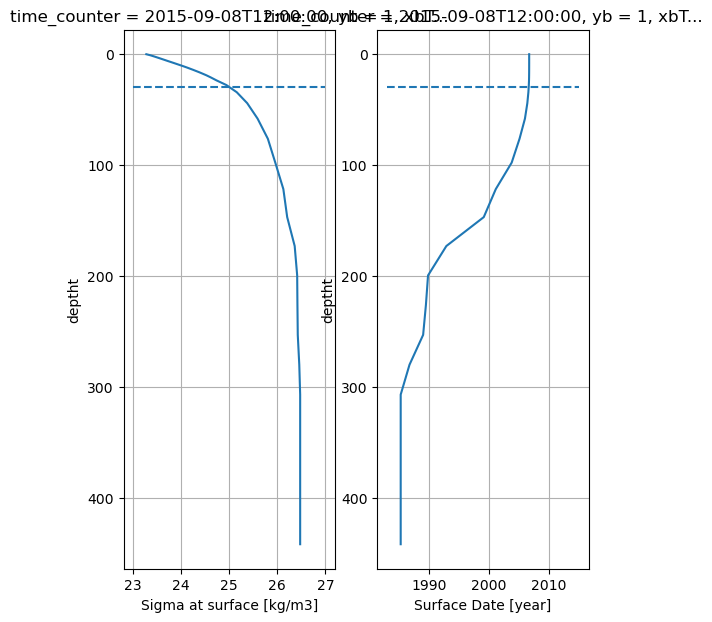

In [8]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(15/5*2, 7))
ds.sigma[0, :, 0, 10].plot(ax = axs[0], y='deptht', yincrease=False);
ds.pycnal_last_at_surface[0, :, 0, 10].plot(ax = axs[1], y='deptht', yincrease=False);

for ax in axs:
    ax.grid();
axs[0].plot([23, 27], [30, 30], '--', color='tab:blue')
axs[1].plot([1983, 2015], [30, 30], '--', color='tab:blue');

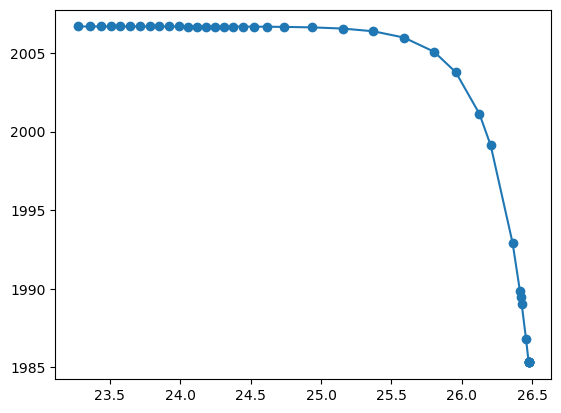

In [9]:
#plot
plt.plot(ds.sigma[0, :, 0, 10], ds.pycnal_last_at_surface[0, :, 0, 10], 'o-');

## Step 2 Find pCO2 at Surface that Year ##

In [10]:
# plot/ check it out
co2_rec = pd.read_csv('../../../analysis_tereza/notebooks/PI_CARBON_PAPER/PI_BOUND_COND/CLEAN/lawdome_maunaloa.csv')
print (co2_rec)
years = [1833.2, 1932, 2017]
for year in years:
    print (co2_rec.iloc[np.argmin(np.abs(co2_rec['YEAR'] - year))]['PPMCO2'])

     YEAR  PPMCO2 Unnamed: 2
0    1832  284.30           
1    1833  284.10           
2    1834  284.00           
3    1835  283.80           
4    1836  283.70           
..    ...     ...        ...
182  2014  398.65        NaN
183  2015  400.83        NaN
184  2016  404.24        NaN
185  2017  406.55        NaN
186  2018  408.52        NaN

[187 rows x 3 columns]
284.1
308.2
406.55


In [73]:
co2_rec.PPMCO2[co2_rec.YEAR == 1836].item()

283.7

In [12]:
ds = pibc.calculate_atpco2_for_watercolumn(ds)

1985.0113387321148


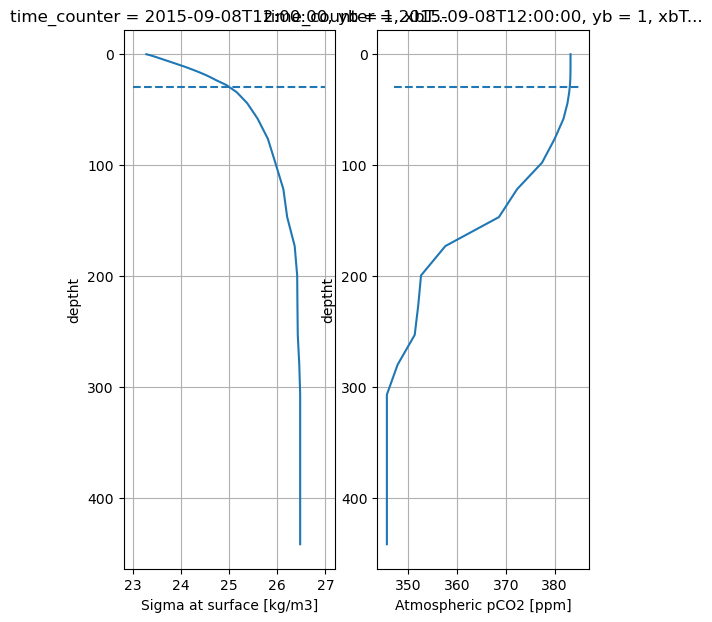

In [13]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(15/5*2, 7))
ds.sigma[0, :, 0, 10].plot(ax = axs[0], y='deptht', yincrease=False);
ds.atpco2[0, :, 0, 10].plot(ax = axs[1], y='deptht', yincrease=False);

for ax in axs:
    ax.grid();
axs[0].plot([23, 27], [30, 30], '--', color='tab:blue')
axs[1].plot([347, 385], [30, 30], '--', color='tab:blue');

Less kinks than Tereza as I have no year truncation.

## Step 3 Find AOU for Water Masses ##

We would expect a different ratio than Redfield (Anderson & Sarmiento, 1994)
Anderson, L. A., & Sarmiento, J. L. (1994). Redfield ratios of remineralization determined by nutrient data analysis. Global Biogeochemical Cycles, 8(1), 65â€“80. https://doi.org/10.1029/93GB03318

In [14]:
ds = pibc.calculate_AOU_in_Carbon(ds)

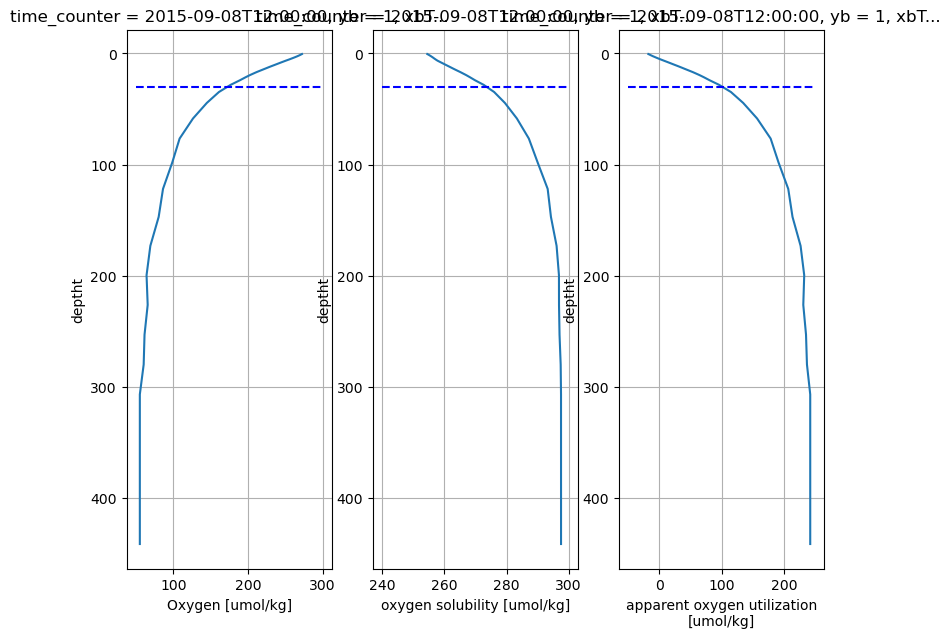

In [15]:
# plot
fig, axs = plt.subplots(1, 3, figsize=(15/5*3, 7))
ds.OXY[0, :, 0, 10].plot(ax = axs[0], y='deptht', yincrease=False);
ds.osol[0, :, 0, 10].plot(ax = axs[1], y='deptht', yincrease=False);
ds.AOU[0, :, 0, 10].plot(ax = axs[2], y='deptht', yincrease=False);

for ax in axs:
    ax.grid();
axs[0].plot([50, 300], [30, 30], '--', color='b')
axs[1].plot([240, 300], [30, 30], '--', color='b');
axs[2].plot([-50, 250], [30, 30], '--', color='b');

## Step 4 Find preformed DIC ##

In [16]:
ds = pibc.calculate_preformed_DIC(ds)

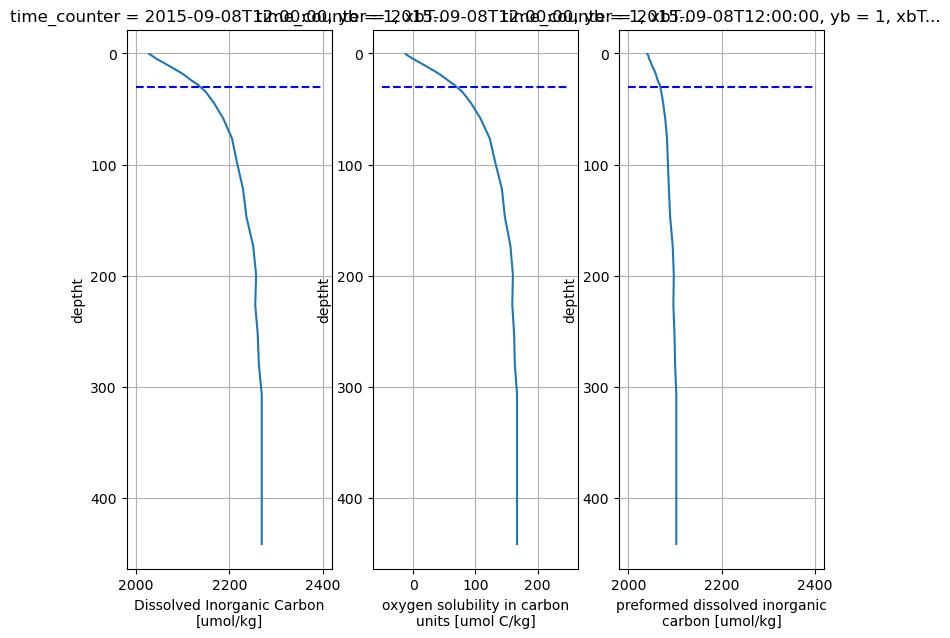

In [17]:
# plot
fig, axs = plt.subplots(1, 3, figsize=(15/5*3, 7))
ds.DIC[0, :, 0, 10].plot(ax = axs[0], y='deptht', yincrease=False);
ds.AOU_stoich[0, :, 0, 10].plot(ax = axs[1], y='deptht', yincrease=False);
ds.preformed_DIC[0, :, 0, 10].plot(ax = axs[2], y='deptht', yincrease=False);

for ax in axs:
    ax.grid();
axs[0].plot([2000, 2400], [30, 30], '--', color='b')
axs[1].plot([-50, 250], [30, 30], '--', color='b');
axs[2].plot([2000, 2400], [30, 30], '--', color='b');

## Step 4b Find Preformed pCO2 ##

Use CO2sys as we need to go back as well and need to be consistent

https://pyco2sys.readthedocs.io/en/latest/

and in particular example 2  https://github.com/mvdh7/PyCO2SYS-examples/blob/master/CO2SYSExample2.ipynb

In [18]:
ds = pibc.calculate_preformed_pCO2(ds)

71.10682397238037


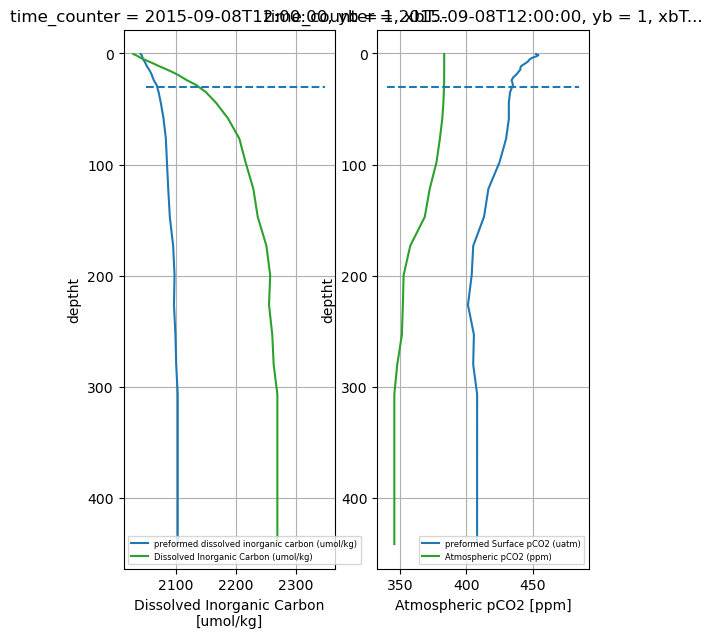

In [19]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(15/5*2, 7))
ds.preformed_DIC[0, :, 0, 10].plot(ax=axs[0], y='deptht', yincrease=False, 
                        label=f'{ds.preformed_DIC.attrs["long_name"]} ({ds.preformed_DIC.attrs["units"]})')           
ds.DIC[0, :, 0, 10].plot(ax=axs[0], y='deptht', yincrease=False, color='tab:green', 
                         label=f'{ds.DIC.attrs["long_name"]} ({ds.DIC.attrs["units"]})')
ds.preformed_pco2[0, :, 0, 10].plot(ax=axs[1], y='deptht', yincrease=False, 
                                    color='tab:blue', 
                        label=f'{ds.preformed_pco2.attrs["long_name"]} ({ds.preformed_pco2.attrs["units"]})')
ds.atpco2[0, :, 0, 10].plot(ax=axs[1], y='deptht', yincrease=False, color='tab:green',
                         label=f'{ds.atpco2.attrs["long_name"]} ({ds.atpco2.attrs["units"]})');

for ax in axs:
    ax.grid();
    ax.legend(prop={'size': 6});
axs[0].plot([2050, 2350], [30, 30], '--', color='tab:blue')
axs[1].plot([340, 485], [30, 30], '--', color='tab:blue');

print (np.max(ds.preformed_pco2[0, :, 0, 10] - ds.atpco2[0, :, 0, 10]).values)

Quite a big difference but early September is probably near maximum

## Step 5 Find Dis-equilibrium pCO2 ##


In [20]:
ds = pibc.calculate_disequ_pCO2(ds)

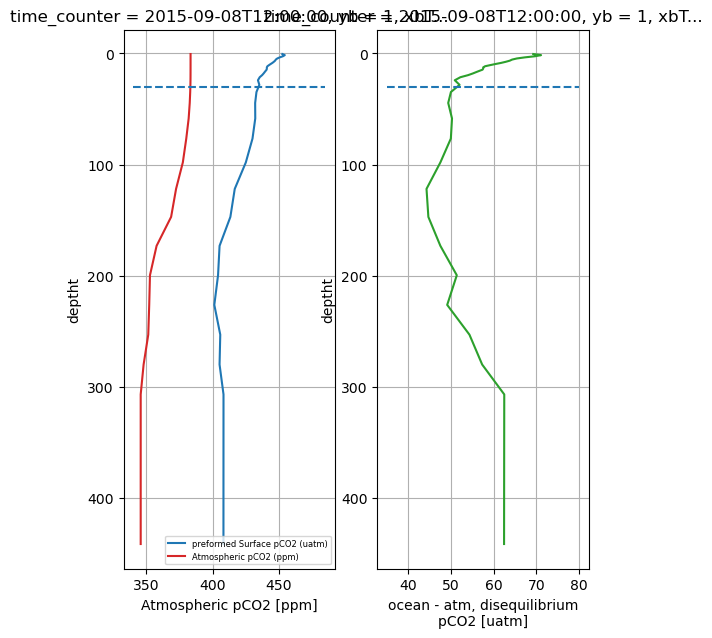

In [21]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(15/5*2, 7))
ds.preformed_pco2[0, :, 0, 10].plot(ax=axs[0], y='deptht', yincrease=False, color='tab:blue',
                        label=f'{ds.preformed_pco2.attrs["long_name"]} ({ds.preformed_pco2.attrs["units"]})')
ds.atpco2[0, :, 0, 10].plot(ax=axs[0], y='deptht', yincrease=False, color='tab:red',
                         label=f'{ds.atpco2.attrs["long_name"]} ({ds.atpco2.attrs["units"]})');   

ds.diseqPCO2[0, :, 0, 10].plot(ax=axs[1], y='deptht', yincrease=False, color='tab:green');

for ax in axs:
    ax.grid();
axs[0].legend(prop={'size': 6});
axs[0].plot([340, 485], [30, 30], '--', color='tab:blue')
axs[1].plot([35, 80], [30, 30], '--', color='tab:blue');

## Step 6 Find PI preformed pCO2 (including disequilbrium) ##


In [22]:
ds = pibc.calculate_preformed_PI_pCO2(ds, assumed_pi_pco2=284)

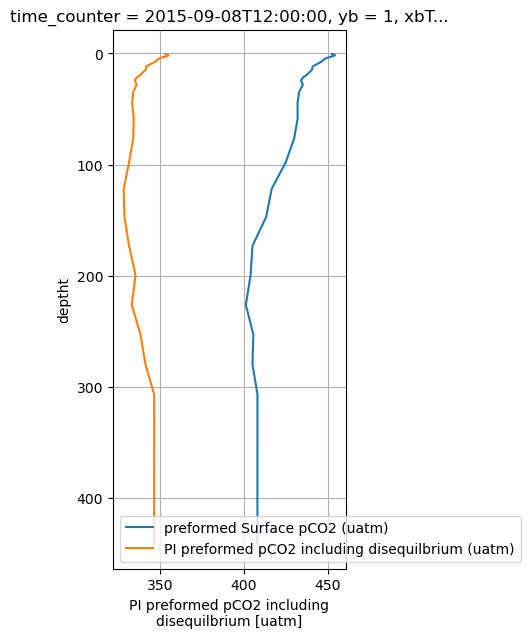

In [23]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(15/5*1, 7))
ds.preformed_pco2[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:blue',
            label=f'{ds.preformed_pco2.attrs["long_name"]} ({ds.preformed_pco2.attrs["units"]})')                       
ds.PIpref_pco2_inc_diseqpco2[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, 
                                               color='tab:orange',
            label=f'{ds.PIpref_pco2_inc_diseqpco2.attrs["long_name"]} ({ds.PIpref_pco2_inc_diseqpco2.attrs["units"]})')
ax.grid();
ax.legend()
axs[0].plot([340, 485], [30, 30], '--', color='tab:blue');

## Step 7 Find PI preformed DIC (including disequilbrium) ##

In [24]:
ds = pibc.calculate_preind_preformed_DIC(ds)

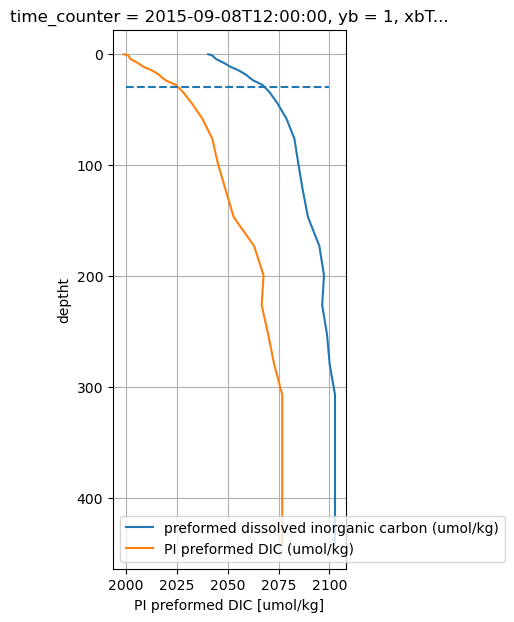

In [25]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(15/5*1, 7))
ds.preformed_DIC[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:blue',
                            label=f'{ds.preformed_DIC.attrs["long_name"]} ({ds.preformed_DIC.attrs["units"]})')
ds.preind_pref_dic[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:orange',
                            label=f'{ds.preind_pref_dic.attrs["long_name"]} ({ds.preind_pref_dic.attrs["units"]})')

ax.grid();
ax.legend()
ax.plot([2000, 2100], [30, 30], '--', color='tab:blue');

## Step 8 Find Delta DIC ##

In [26]:
# Calculate delta DIC
ds = pibc.calculate_delta_DIC(ds)

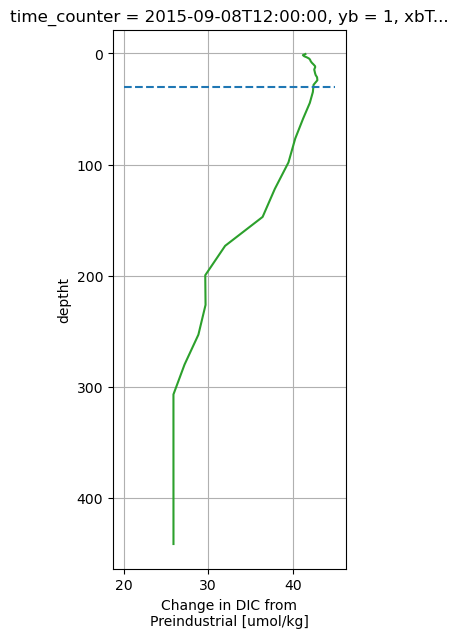

In [27]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(15/5*1, 7))
ds.deltaDIC[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:green',
                                   );
ax.grid();
ax.plot([20, 45], [30, 30], '--', color='tab:blue');

## Step 9 : Final PI DIC ##

In [28]:
# find PI DIC
ds = pibc.calculate_final_deep_DIC(ds)

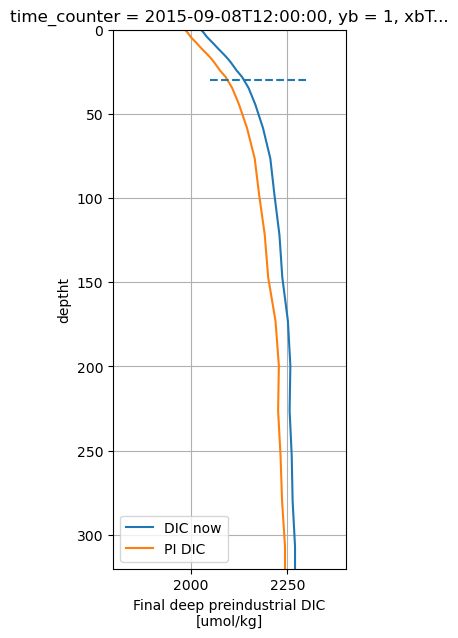

In [29]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(15/5*1, 7))
ds.DIC[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:blue',
                                   label='DIC now');
ds.Final_PI_DIC[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:orange',
                                    label='PI DIC');

ax.grid();
ax.legend()
ax.set_xlim(1800, 2400)
ax.set_xticks([2000, 2250])
ax.set_ylim(320, 0)
ax.plot([2050, 2300], [30, 30], '--', color='tab:blue');

##  Compare to Tereza's ##

Tereza's value for September (note different units)
![title](../../../analysis_tereza/notebooks/PI_CARBON_PAPER/PI_BOUND_COND/CLEAN/September.png)

1986.6882008635455


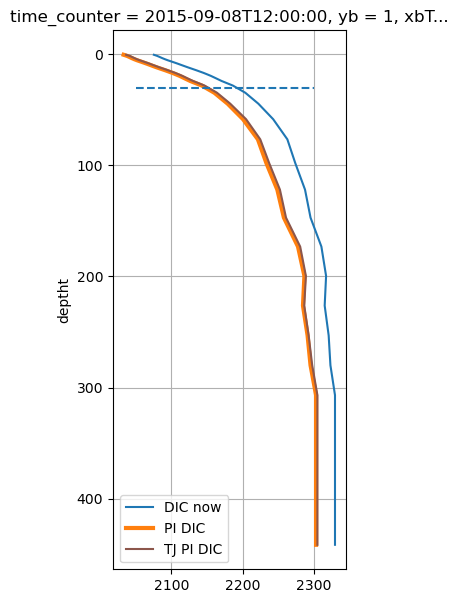

In [30]:
# plot
tj = xr.open_dataset('../../../analysis_tereza/notebooks/PI_CARBON_PAPER/PI_BOUND_COND/CLEAN/preind_DIC/LO_AOUmethod_stoicCO_diseq_allup_y2015m09d08_preind_DIC.nc',
                    group='preindustrial_DIC')
conversion_uMolar_to_umolkg = 1000 / (1000 + ds.sigma)
fig, ax = plt.subplots(1, 1, figsize=(15/5*1, 7))
ds.DIC_uMol[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:blue',
                                   label='DIC now');
(ds.Final_PI_DIC[0, :, 0, 10]/conversion_uMolar_to_umolkg[0, :, 0, 10]).plot(ax=ax, y='deptht', yincrease=False, color='tab:orange',
                                    label='PI DIC', linewidth=3);
ax.plot(tj.preind_dic[:, 10], ds.deptht, color='tab:brown',
                          label='TJ PI DIC')
                          
ax.grid();
ax.legend()
ax.plot([2050, 2300], [30, 30], '--', color='tab:blue');
print (ds['Final_PI_DIC'][0, 0, 0, 10].values)

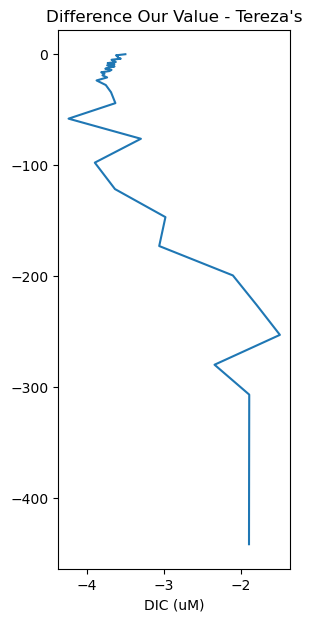

In [31]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(15/5*1, 7))
ax.plot((ds.Final_PI_DIC[0, :, 0, 10]/conversion_uMolar_to_umolkg[0, :, 0, 10]).values - tj.preind_dic[:, 10].values, -ds.deptht)
ax.set_title("Difference Our Value - Tereza's");
ax.set_xlabel("DIC (uM)");

## Step 10: Correct Near Surface Values

From Tereza's paper or thesis:  
*The cfc tracer method is not appropriate for very young waters, so we do not use it for lower-density waters (σθ <25.0). These lower density waters are typically recently-ventilated waters found near the surface and are likely to be tracking the current atmospheric CO2 concentra- tions. I used a surface intrusion value of 60 mmol m−3 for these waters (σθ <25.0); this estimate is within the range of the reported surface values for the shelf values in the region based on (Feely et al., 2016) and the broader open Pacific (Carter et al., 2019). To avoid discontinuities in the carbon field, for every depth profile I then linearly interpolated from a value of 60 mmol m−3 at surface to the value at σθ =25.0.*

Debby's algorithm:
9 July 2025 DI
Algorithm to determine surface DIC at the JdF boundary for the pre-industrial year ("dic-pi")'
assuming live-ocean data are available for present day
#############################################################

############################################################.  
(1) read live ocean data (at JdF boundary)
- date(t), salinity(SA), temperature(CT), po4, si, DIC, TA    

###########################################################.  
(2) convert units (as necessary)
    (a) model salinity (SA) to practical salinity (S) (because pyco2sys requires S)
    (b) conservative temperature to (T) 
    (c) z to pressure (P) 
    (d) nutrients to umol/kg (gsw.density)
 after this point all units are 'observationalist' units - convert to model units at the very end of algorithm.  
###########################################################  
(3) determine PCO2 atmosphere = f(time) for present day ("pCO2a-pd") and then preindustrial ("pCO2a-pi")  
     - use TJ's equations for seasonal cycle and annual mean
     - (a) calculate zz_yearcyc (same for both)
     - (b) calculate zz_aco2 for present day ("pCO2a-pd")
     - Cc) calculate zz_aco2 for present day ("pCO2a-pi")

##### Fortran code pasted here - from SEA 24-June-2025 email:
z_day = nday_year

      zz_yearcyc =  zz_amp * exp( -((zz_day - zz_ctr)/zz_wid)**2)&
              + zz_amp2 * exp( -((zz_day - zz_ctr2)/zz_wid2)**2)&
              + zz_amp3 * exp( -((zz_day - zz_ctr3)/zz_wid3)**2)

      zz_atcco2 = (zz_year+(zz_day/365))*zz_LR_slope+zz_LR_int + zz_yearcyc

where nday_year is the year day,
zz_year is the year (aka 2025)
   zz_LR_slope   =  2.149     !  linear regression + gaussian fit 
   zz_LR_int     =  -3929.359 !  to seasonal cycle of atmospheric co2
   zz_ctr        =  161.898   !  based on scripps observations at ptbarrow and lajolla
   zz_amp        =  7.083     !  calc notebook by TJSJ
   zz_wid        =  44.703    !  notebook loc:
   zz_ctr2       =  218.832   !  carbon_dev/MOCSY_and_FLUX/CO2_obs.ipynb
   zz_amp2       =  -19.004   !
   zz_wid2       =  87.8836   !
   zz_ctr3       =  199.430   !
   zz_amp3       =  8.026     !
   zz_wid3       =  -185.920  !

Cheers,
Susan
#####

###########################################################.   
(4) determine the dissolved inorganic carbon at the surface if ocean surface ocean pCO2 were equal to atmsopheric pCO2
on that day (dic_eqm) using pyco2sys: dic_eqm for present day dic_eqm_pd and preindustrial (dic_eqm_pi) 
Thus dic_eqm is calculated using pyco2sys with input S,T,TA,pCO2a,po4,si (for pd and pi all input is the same *except pCO2a)
(a) determine dic_eqm_pd (present day)
(a) determine dic_eqm_pi (preindustrial)

####my code
#### determine carbonate system with a dic at eqm with atmosphere

kwargs = {
    "salinity": df["S"],  # Salinity of the sample --pracical salinitypsu
    "temperature": df["T"],  # Temperature at input conditions -- degC
    "pressure": df["P"],  # Pressure, dic and ta collected at  -- dbar
    "total_silicate": df["si_kg"],  # Concentration of silicate  in the sample (in umol/kg)
    "total_phosphate": df["po4_kg"],  # Concentration of phosphate in the sample (in umol/kg)
    "opt_k_carbonic": 14,  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
    "opt_k_bisulfate": 1,  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")
}

results_eq_pd = pyco2.sys(
    par1 = df["TA"],
    par1_type = 1,         # TA - using ta-js rel (umol/kg) 
    par2 = df["pCO2a-pd"],
    par2_type = 4,         # pCO2 - pCO2 atmosphere (uatm)
    **kwargs
)

results_eq_pi = pyco2.sys(
    par1 = df["TA"],
    par1_type = 1,         # TA - using ta-js rel (umol/kg)
    par2 = df["pCO2a-pi"],
    par2_type = 4,         # pCO2 - pCO2 atmosphere (uatm)
    **kwargs
)

####

############################################################
(5) determine dissolved inorganic carbon (dic_diseq) at the surface of the JdF boundary 
    {dic = live ocean surface present day dic}

    dic_diseq = dic - dic_eqm_pd

############################################################
(6) determine JdF surface DIC at the boundary for preindustrial time - "dic-pi"
       - here we assume that the dic_disequilibrium (dic_diseq) with the atmosphere is the same throughtout time
       - the method is called the 'delta-dic' method, developed for determining the anthropogenic dic intrusion since
         preindustrial time (delta-dic)   
         (Matsumoto & Gruber 2005;Pacella et al.2018)
       - see para1 in 2.5 Simpson et al. 2022 for more mechanistic explanation  


dic_pi = dic_eq-pi(from algorithm step-4) + dic_diseq(from step-5)

###########################################################
(7) Convert dic and ta from observational to model units
(umol/kg to uM)
###########################################################


References:

Matsumoto, K., & Gruber, N. (2005). 
How accurate is the estimation of anthropogenic carbon in the ocean? An evaluation of the Î” C* method. 
Global Biogeochemical Cycles, 19(3), 1â€“17. 
https://doi.org/10.1029/2004GB002397

Pacella, S. R., Brown, C. A., Waldbusser, G. G., Labiosa, R. G., & Hales, B. (2018). 
Seagrass habitat metabolism increases short-term extremes and long-term offset of CO2 under future ocean acidification. 
Proceedings of the National Academy of Sciences of the United States of Amer- ica, 115(15), 3870â€“3875. 
https://doi.org/10.1073/pnas.1703445115

## Step One ##
- complete (ds.vosaline, ds.votemper, ds.NO3, ds.Si, ds.DIC, ds.TA)
- latter 4 converted to umol/kg
## Step Two ##
- complete (ds.practical_salinity, ds.potential_temperature, ds.pressure)
## Step Three ##
- for surface pco2, I'm using 3 functions:
    - 1832 to 1950: observations
    - 1950 to 2000: polynomial fit to observations
    - 2000 on: SalishSeaCast linear extrapolation

In [32]:
time_as_years = ds.time_counter.astype(float)/86400/365/1e9 + 1970
preindustrial = 1840 + time_as_years - np.trunc(time_as_years)
(surface_atpco2_now, surface_atpco2_pi)  = pibc.surface_atpco2_for_year(ds, time_as_years, preindustrial, include_seasonal=True)
# note, only two values here
print (surface_atpco2_now[0])

2015.7164383561644
1840.7164383561644
[[0.71643836]]
[[2.52067971]]
[402.41562603]


## Step Four ##
Only for surface!
- DIC if atpco2 was current values
- DIC if atpco2 was pi value

In [33]:
ds = pibc.calculate_equilibrium_DIC(ds, surface_atpco2_now[0], 'dic_equ_atmos_now', 'DIC if ocean pCO2 in equilibrium with atmos pCO2 now')
ds = pibc.calculate_equilibrium_DIC(ds, surface_atpco2_pi[0], 'dic_equ_atmos_pi', 'DIC if ocean pCO2 in equilibrium with atmos pCO2 PI')

In [34]:
print (ds.dic_equ_atmos_now[0, 0, 10])
print (ds.dic_equ_atmos_pi[0, 0, 10])
print ((ds.dic_equ_atmos_now[0, 0, 10] - ds.dic_equ_atmos_pi[0, 0, 10]).values)

<xarray.DataArray 'dic_equ_atmos_now' ()> Size: 8B
array(2021.29332742)
Coordinates:
    time_counter  datetime64[ns] 8B 2015-09-08T12:00:00
    yb            int64 8B 1
    xbT           int64 8B 10
Attributes:
    long_name:  DIC if ocean pCO2 in equilibrium with atmos pCO2 now
    units:      umol/kg
<xarray.DataArray 'dic_equ_atmos_pi' ()> Size: 8B
array(1960.68370175)
Coordinates:
    time_counter  datetime64[ns] 8B 2015-09-08T12:00:00
    yb            int64 8B 1
    xbT           int64 8B 10
Attributes:
    long_name:  DIC if ocean pCO2 in equilibrium with atmos pCO2 PI
    units:      umol/kg
60.6096256648525


## Step 5 ##
Find now disequilbrium surface DIC 
{dic = live ocean surface present day dic}

    dic_diseq = dic - dic_eqm_pd

In [35]:
ds = pibc.calculate_dic_diseq(ds)

In [36]:
# print
print (ds.dic_equ_atmos_now[0, 0, 10])
print (ds.DIC[0, 0, 0, 10])
print(ds.dic_diseq[0, 0, 10].values)

<xarray.DataArray 'dic_equ_atmos_now' ()> Size: 8B
array(2021.29332742)
Coordinates:
    time_counter  datetime64[ns] 8B 2015-09-08T12:00:00
    yb            int64 8B 1
    xbT           int64 8B 10
Attributes:
    long_name:  DIC if ocean pCO2 in equilibrium with atmos pCO2 now
    units:      umol/kg
<xarray.DataArray 'DIC' ()> Size: 8B
array(2028.18814656)
Coordinates:
    time_counter  datetime64[ns] 8B 2015-09-08T12:00:00
    deptht        float64 8B 0.5
    yb            int64 8B 1
    xbT           int64 8B 10
Attributes:
    grid:       SalishSea2
    long_name:  Dissolved Inorganic Carbon
    units:      umol/kg
6.894819146443751


## Step 6 ##

- determine JdF surface DIC at the boundary for preindustrial time - "dic-pi"
- dic_pi = dic_eq-pi(from algorithm step-4) + dic_diseq(from step-5)

In [37]:
ds = pibc.calculate_surf_DIC_PI(ds)

In [38]:
# print
print (ds.dic_equ_atmos_now[0, 0, 10].values)
print (ds.dic_diseq[0, 0, 10].values)
print(ds.surf_DIC_PI[0, 0, 10])
print((ds.surf_DIC_PI[0, 0, 10] - ds.DIC[0, 0, 0, 10]).values)

2021.293327418545
6.894819146443751
<xarray.DataArray 'surf_DIC_PI' ()> Size: 8B
array(1967.5785209)
Coordinates:
    time_counter  datetime64[ns] 8B 2015-09-08T12:00:00
    yb            int64 8B 1
    xbT           int64 8B 10
Attributes:
    long_name:  PI Surface DIC
    units:      umol/kg
-60.6096256648525


In [39]:
# Calculate: I don't love this, it has a loop
ds, depth_crit, intrusion_at_crit, intrusion_values = pibc.correct_near_surface_DIC(ds)

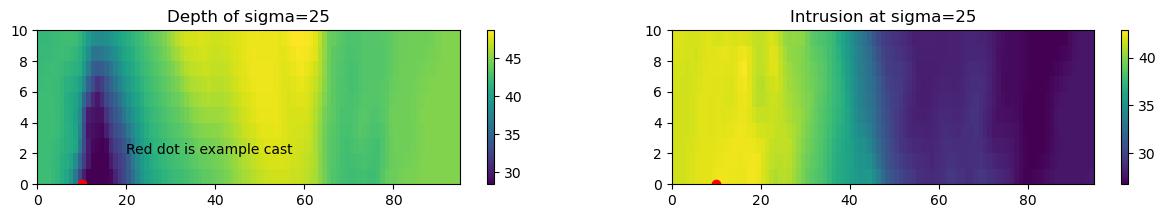

In [40]:
# plot
#
fig, axs = plt.subplots(1, 2, figsize=(15, 2))
colours = axs[0].pcolormesh(depth_crit.reshape(10, 95))
fig.colorbar(colours, ax=axs[0]);
colours = axs[1].pcolormesh(intrusion_at_crit.reshape(10, 95))
fig.colorbar(colours, ax=axs[1]);
for ax in axs:
    ax.plot(10, 0, 'ro');
axs[0].set_title("Depth of sigma=25")
axs[1].set_title("Intrusion at sigma=25")
axs[0].text(20, 2, "Red dot is example cast");

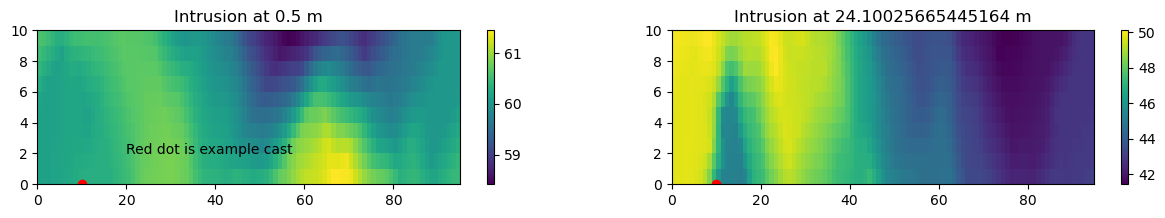

In [41]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(15, 2))
colours = axs[0].pcolormesh(intrusion_values[0].reshape(10, 95))
fig.colorbar(colours, ax=axs[0]);
colours = axs[1].pcolormesh(intrusion_values[20].reshape(10, 95))
fig.colorbar(colours, ax=axs[1]);
for ax in axs:
    ax.plot(10, 0, 'ro');
axs[0].set_title("Intrusion at 0.5 m")
axs[1].set_title(f'Intrusion at {ds.deptht[20].values} m')
axs[0].text(20, 2, "Red dot is example cast");

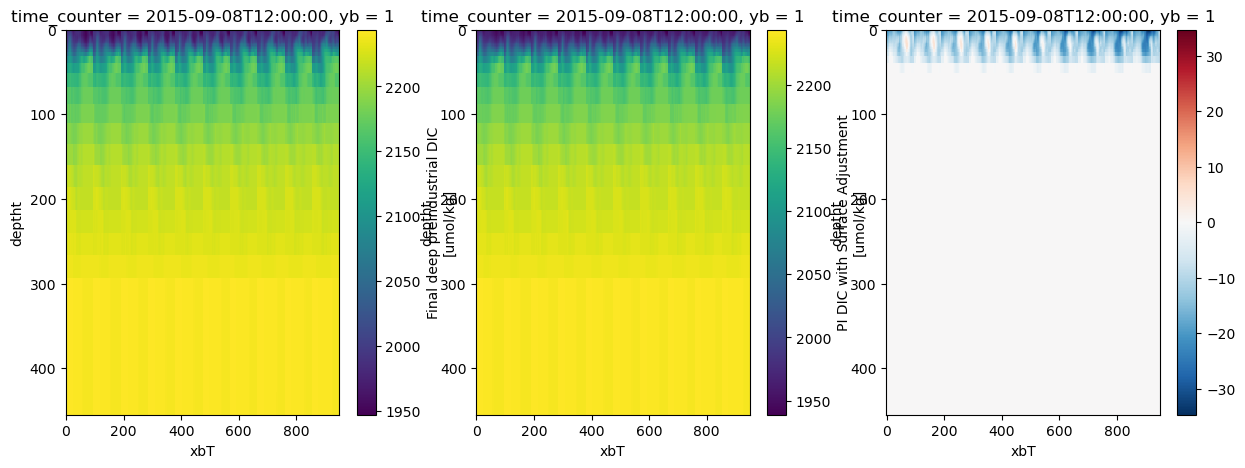

In [42]:
# plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
ds['Final_PI_DIC'][0, :, 0, :].plot(y='deptht', yincrease=False, ax=axs[0])
ds['PI_DIC_w_surf_corr'][0, :, 0, :].plot(y='deptht', yincrease=False, ax=axs[1])
(ds['PI_DIC_w_surf_corr'][0, :, 0, :]-ds['Final_PI_DIC'][0, :, 0, :]).plot(y='deptht', yincrease=False, ax=axs[2]);

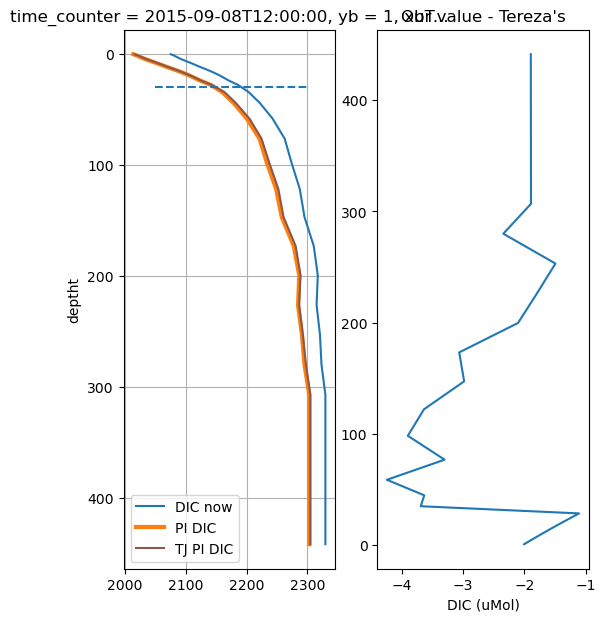

In [43]:
# plot
tj = xr.open_dataset('/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/PI_CARBON_PAPER/PI_BOUND_COND/CLEAN/PREIND_BCCOND/PI_AOU_SIGADJ_v201905_y2015m09d08.nc',
                    #group='preindustrial_DIC'
                    )
conversion_uMolar_to_umolkg = 1000 / (1000 + ds.sigma)
fig, axs = plt.subplots(1, 2, figsize=(15/5*2, 7))
ds.DIC_uMol[0, :, 0, 10].plot(ax=axs[0], y='deptht', yincrease=False, color='tab:blue',
                                   label='DIC now');
(ds.PI_DIC_w_surf_corr[0, :, 0, 10]/conversion_uMolar_to_umolkg[0, :, 0, 10]).plot(ax=axs[0], y='deptht', yincrease=False, color='tab:orange',
                                    label='PI DIC', linewidth=3);
axs[0].plot(tj.DIC[0, :, 0, 10], ds.deptht, color='tab:brown',
                          label='TJ PI DIC')

axs[0].grid();
axs[0].legend()
axs[0].plot([2050, 2300], [30, 30], '--', color='tab:blue');
axs[1].plot( ds.PI_DIC_w_surf_corr[0, :, 0, 10]/conversion_uMolar_to_umolkg[0, :, 0, 10] - tj.DIC[0, :, 0, 10], ds.deptht),
axs[1].set_title("Our value - Tereza's")
axs[1].set_xlabel("DIC (uMol)");

### Last Step ###

Convert to uMol
Write new DIC files

In [50]:
pibc.write_file(ds, date, conversion_uMolar_to_umolkg)

In [51]:
! ls -l PI*

-rw-r--r-- 1 sallen bluetooth   16016 Jul 28 15:06 PI_BOUND_COND.py
-rw-r--r-- 1 sallen bluetooth 7650764 Apr  9  2022 PIData_for_Spring.nc
-rw-r--r-- 1 sallen bluetooth    4902 Apr 10  2022 PIData_for_SpringRegionals.ipynb
-rw-r--r-- 1 sallen bluetooth  206076 Jul 28 15:06 PI_JdF_DIC_v20250708_y2015m09d08.nc
-rw-r--r-- 1 sallen bluetooth  206076 Jul 28 14:54 PI_JdF_DIC_v20250708_y2015m9d8.nc


In [55]:
date.timestamp()/365.25/86400 + 1970

2015.6845767738992

In [56]:
from_notebook = xr.open_dataset('PI_JdF_DIC_v20250708_y2015m9d8.nc')
from_script = xr.open_dataset('PI_JdF_DIC_v20250708_y2015m09d08.nc')

In [60]:
from_script.PI_DIC_w_surf_corr_uMol

<xarray.DataArray 'PI_DIC_w_surf_corr_uMol' (time_counter: 1, deptht: 40,
                                             yb: 1, xbT: 950)> Size: 304kB
[38000 values with dtype=float64]
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 8B 2015-09-08T12:00:00
  * deptht        (deptht) float64 320B 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
  * yb            (yb) int64 8B 1
  * xbT           (xbT) int64 8kB 0 1 2 3 4 5 6 ... 943 944 945 946 947 948 949
Attributes:
    long_name:  PI DIC with Surface Adjustment in uMol
    units:      mmol/m3

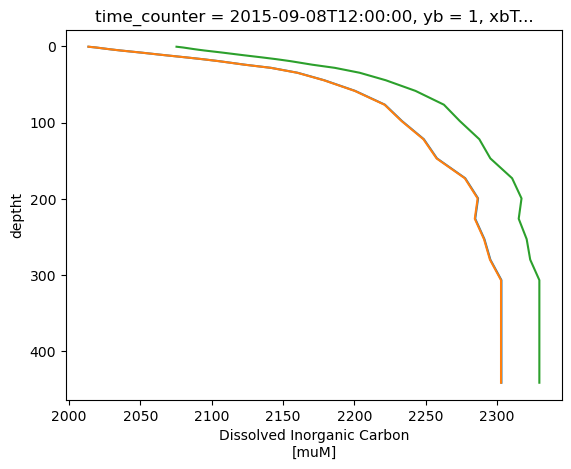

In [64]:
from_notebook.PI_DIC_w_surf_corr_uMol[0, :, 0, 10].plot(y='deptht', yincrease=False)
from_script.PI_DIC_w_surf_corr_uMol[0, :, 0, 10].plot(y='deptht', yincrease=False)
ds.DIC_uMol[0, :, 0, 10].plot(y='deptht', yincrease=False);